In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, \
GlobalMaxPooling2D, Conv2DTranspose, Lambda, Dropout, concatenate
from sklearn.model_selection import train_test_split
import os
import json
from PIL import Image

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

import random

from scipy import stats

import zipfile,fnmatch,os
from zipfile import ZipFile

seed = 42
np.random.seed =seed

In [21]:
def create_x_gt_list(TRAIN_PATH, GT_PATH):
    """
    input: path to root directories of training and ground truth images 
    as taken from MIT image dataset of personal ids
    created for image size (1920, 1080, IMG_CHANNELS)
    
    output: arrays of images (455, 256, IMG_CHANNELS)
    
    !!!explain: (30*col_num+fil_num)
    """
    
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    IMG_CHANNELS = 3
    
    train_ids = next(os.walk(TRAIN_PATH))[1]
    gt_ids = next(os.walk(GT_PATH))[1]


    file_names = []
    
    #list all files within a TRAIN_PATH/folder
    for folder in next(os.walk(TRAIN_PATH))[1]:
        file_names.append(next(os.walk(TRAIN_PATH + folder))[2])

    files = []
    
    #remove .tif extension from filenames
    for name in file_names:
        files.append([s.replace('.tif', '') for s in name])
    
    x_img_array = np.zeros((len(file_names)*len(files[0]), \
                            IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.int32)
    
    gt_img_array = np.zeros((len(file_names)*len(files[0]), \
                            IMG_HEIGHT, IMG_WIDTH), dtype=np.int32)
    
    y_img_array = np.zeros((len(file_names)*len(files[0]), \
                            IMG_HEIGHT, IMG_WIDTH), dtype=np.int32)
    
    #for each file in each folder, load the image, process it and
    #write it to corresponding array (30*col_num+fil_num) is used
    #because there are 30 images per folder    
    for col_num, foldername in tqdm(enumerate(train_ids), total=len(train_ids)):
        for fil_num, filename in enumerate(files[col_num]):

            img_path = TRAIN_PATH + f'{foldername}/' + filename + '.tif'
            gt_path = GT_PATH + f'{foldername}/'+ filename + '.json'
            
    #load bgr image as img_bgr and create copy img_temp for countouring
    #create temp copy of img_bgr because opencv changes the original image
            img_bgr = cv2.imread(img_path)
            img_temp = np.array(img_bgr)
            img_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)

    ### check if all images are (1920, 1080)
#             if img_temp.shape != (1920, 1080):
#                 print(f'shape of the image is not (1920, 1080), it is {img_temp.shape}')
#                 break
                
            img_bgr_res = cv2.resize(img_bgr, \
                                    (IMG_WIDTH, IMG_HEIGHT),\
                                    interpolation=cv2.INTER_AREA)


            x_img_array[(30*col_num+fil_num)] = img_bgr_res         
        
    #open, read and close json file that contains contour coordinates 
    #contour ctr is an angled rectangle(quad)
            gt_open = open(gt_path)
            gt_dict = json.load(gt_open)
            ctr = np.array(gt_dict['quad']).reshape((-1, 1,2)).astype(np.int32)
            gt_open.close()
            
    #draw contours if needed
    #         img_contour = cv2.drawContours(img_temp, [ctr], 0,(255,255,255),20)
    
    #fill the contour [ctr], resize and enter value to ground_truth array
            img_fill = cv2.fillPoly(img_temp, pts=[ctr], color=(0,0,0))
            img_fill_res = cv2.resize(img_fill, \
                                    (IMG_WIDTH, IMG_HEIGHT),\
                                    interpolation=cv2.INTER_AREA)
            gt_img_array[(30*col_num+fil_num)] = img_fill_res
            
    #transform ground_truth array to array containing 1 for filled area, 0 for outside the area
            y_img_array[(30*col_num+fil_num)] = image_thresh_and_invert(img_fill_res)
    
    return x_img_array, gt_img_array, y_img_array


def image_thresh_and_invert(img_fill):
    """perform tresholding to set everything outside filled area to 255
    perform bitwise inversion to set filled area to 255 and everything else to 0
    (so filled area will have values of 1 after normalization)"""
    
    _, y_temp = cv2.threshold(img_fill, 0, 255, cv2.THRESH_BINARY)

    return cv2.bitwise_not(y_temp)
        
def sweep_for_number_of_files(ids_location):
    """
    returns number of training files in folder ids/
    """
    
    file_names = []
    i = 0
    for idx, foldername in enumerate(next(os.walk(f'{ids_location}'))[1]):
        TRAIN_PATH = f'{ids_location}/{foldername}/images/'
        GT_PATH = f'{ids_location}/{foldername}/ground_truth/'
        for folder in next(os.walk(TRAIN_PATH))[1]:
            i = i + (len((next(os.walk(TRAIN_PATH + folder))[2])))

    return i


In [22]:
def create_image_arrays(ids_location, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    """
    creates arrays containing training, ground_truth and mask images
    
    x_img_array - training images
    gt_img_array - ground_truth images
    y_img_array - mask images
    entry_ex - starting counter for sequential entry of images for specific foldername
    entry_num - number of files in specific foldername
    """
    
    fnames = next(os.walk(f'{ids_location}'))[1]
    x_img_array = np.zeros((sweep_for_number_of_files(ids_location), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    gt_img_array = np.zeros((sweep_for_number_of_files(ids_location), IMG_HEIGHT, IMG_WIDTH))
    y_img_array = np.zeros((sweep_for_number_of_files(ids_location), IMG_HEIGHT, IMG_WIDTH))

    entry_ex = 0
    for idx, foldername in enumerate(next(os.walk(f'{ids_location}'))[1]):
            TRAIN_PATH = f'{ids_location}/{foldername}/images/'
            GT_PATH = f'{ids_location}/{foldername}/ground_truth/'

            x, gt, y = create_x_gt_list(TRAIN_PATH, GT_PATH)
            
            entry_num = x.shape[0]

            x_img_array[entry_ex:(entry_ex+entry_num)] = x[:]
            gt_img_array[entry_ex:(entry_ex+entry_num)] = gt[:]
            y_img_array[entry_ex:(entry_ex+entry_num)] = y[:]
            entry_ex = entry_ex+entry_num
            
    
    return x_img_array, gt_img_array, y_img_array

In [23]:
def build_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    """
    UNET architecture
    """

    #build the model
    input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    #contraction path
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (input_layer)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
 
    #expansive path
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)

    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=[input_layer], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
#size of UNET input layer
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

home_location = '/home/oioioio/Documents/Python/id_dataset'
ids_location = f'{home_location}/ids/'

In [25]:
# #create arrays

# x_img_array, gt_img_array, y_img_array = create_image_arrays(ids_location, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [26]:
#save / load non normalized arrays of images

# np.save(f'{home_location}/datasets/x_img_array', x_img_array)
# np.save(f'{home_location}/datasets/gt_img_array', gt_img_array)
# np.save(f'{home_location}/datasets/y_img_array', y_img_array)
x_img_array = np.load(f'{home_location}/datasets/x_img_array.npy')
# gt_img_array = np.load(f'{home_location}/datasets/gt_img_array.npy')
y_img_array = np.load(f'{home_location}/datasets/y_img_array.npy')

In [27]:
x_img_array.shape

(1500, 256, 256, 3)

In [28]:
#creating training and test sets by rotating image and making negatives: 
#[::-1, :, :] vertical flip
#[:, ::-1, :] horizontal flip
#(1 - X_train) image negative

X_train_temp = x_img_array/255
X_train = np.concatenate([X_train_temp[:][:, :, :]])

Y_train_temp = np.expand_dims(y_img_array/255, axis=3).astype(np.bool)
Y_train = np.concatenate([Y_train_temp[:][:, :, :], Y_train_temp[:][::-1, ::-1, :]])

X_test = np.concatenate([X_train_temp[0:550][:, ::-1, :]])
Y_test = np.concatenate([Y_train_temp[0:550][:, ::-1, :]])


663


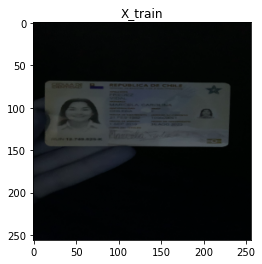

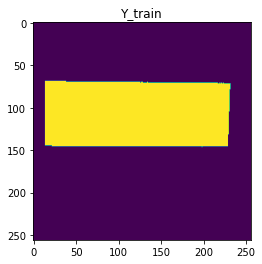

168


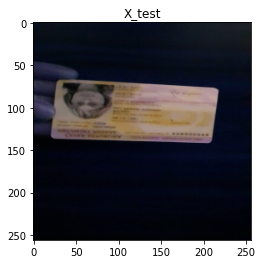

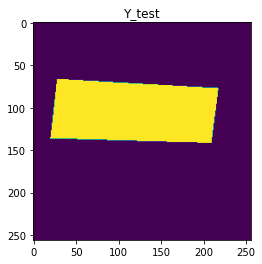

In [29]:
#check X_train and X_test images for correspondng masks Y_train and Y_test on random image i

i = np.random.randint(0, len(X_train))

print(i)
plt.imshow(X_train[i])
plt.title('X_train')
plt.show()
plt.imshow(np.squeeze((Y_train[i]), axis=2))
plt.title('Y_train')
plt.show()



j = np.random.randint(0, len(X_test))

print(j)
plt.imshow(X_test[j])
plt.title('X_test')
plt.show()
plt.imshow(np.squeeze((Y_test[j]), axis=2))
plt.title('Y_test')
plt.show()
    

In [30]:
# #build model, create callbacks, model fitting, model evaluation

# model = build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('model_for_licna_karta.h5', verbose=1, save_best_only=True),
#     tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')]

# results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=15, epochs=25, callbacks=callbacks)

# model.evaluate(X_test, Y_test, verbose=1)

In [31]:
# #show training and validation accuracy and loss

# %matplotlib inline
# import matplotlib.pyplot as plt
# acc = results.history["accuracy"] # Your Code Here
# val_acc = results.history["val_accuracy"] # Your Code Here
# loss = results.history["loss"]# Your Code Here
# val_loss = results.history["val_loss"]# Your Code Here

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()


In [32]:
#load previously trained model

model = tf.keras.models.load_model(f'{home_location}/model_for_licna_karta.h5')

In [33]:
#perform prediction

pred_img = model.predict(X_test, verbose=1)
pred_img_t = np.zeros(pred_img.shape)
pred_img_t = (pred_img>0.5).astype(np.bool)

18/18 [==============================] - 1s 70ms/step


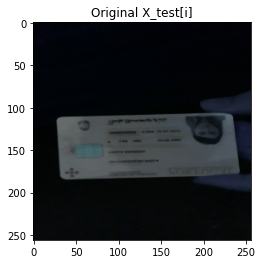

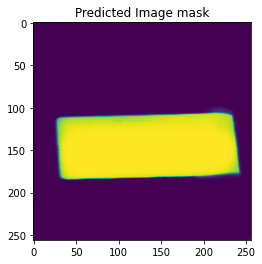

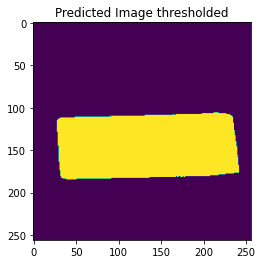

In [34]:
i = np.random.randint(0, len(pred_img_t[0]))

plt.imshow((X_test[i]))
plt.title('Original X_test[i]')
plt.show()

plt.imshow(np.squeeze(pred_img[i], axis=2))
plt.title('Predicted Image mask')
plt.show()

plt.imshow(np.squeeze(pred_img_t[i], axis=2))
plt.title('Predicted Image thresholded')
plt.show()


In [35]:
###background removal

def background_removal(img, mask):
    """
    performs background removal for image based on mask
     - mask.shape is (256, 256, 1) - based on Y_train
     - Y_train.dtype is "bool" so it should be converted to
    numerical value ("float32 to match pred_img[i].dtype) prior to
    normalization to "uint8"
     - pred_img[i].dtype is "float32", so mask is converted
    to "uint8" prior to background removal
     - masked - img with removed background
     - masked.dtype is "float64"
    """

    mask = cv2.normalize(mask.astype("float32"), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    masked = cv2.bitwise_and(img, img, mask=mask)

    return masked


###contour detection steps 0-4


def convert_to_gray_and_threshold(masked, T=20):
    #step 0: convert from float32 to uint8 (cvtColor works with uint8 by default)
    masked_uint = cv2.normalize(masked, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
#     masked_uint_copy[:] = masked_uint[:]
    
    #step 1: convert to grayscale
    img_gray = cv2.cvtColor(masked_uint, cv2.COLOR_BGR2GRAY)


    #step 2: apply binary thresholding
    """
    values greater than T will be converted to 255
    """

    ret, thresh = cv2.threshold(img_gray, T, 255, cv2.THRESH_BINARY)

    return(masked_uint, thresh)
    
def contour_detection(masked_uint, thresh):
    #step 3: find contours
    """
    contours.shape = (x, y, z, s)
    x - number of contours
    y - number of points per contour
    z - ?
    s - coordinates of each point

    len(hierarchy) = 1 - for now I haven't encountered otherwise
    hierarchy[0].shape = (x, a)
    a - [Next, Previous, First_Child, Parent]
    Next - Next denotes next contour at the same hierarchical level
    Previous - Previous denotes previous contour at the same hierarchical level
    First_child - First_Child denotes its first child contour.
    Parent - Parent denotes index of its parent contour

    mode - Contour Retrieval Mode
    RETR_LIST, RETR_EXTERNAL, RETR_CCOMP, RETR_TREE

    """
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

    #step 4: draw contours to a copy of original image(masked_uint)
    masked_uint_copy = masked_uint.copy()
    cv2.drawContours(image=masked_uint_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)

#     print(masked_uint.max())
#     plt.imshow(masked_copy)
    
    return(masked_uint_copy)

###corner detection

def corner_detection(masked_uint, thresh, N=4):
    """
    N - number of corners
    returns positions of N corners, rearranged for warpPerspective corner point positions
    """

    pts_corners = np.zeros([N, 2])
    #convert to grayscale:
    corners = cv2.goodFeaturesToTrack(thresh, N, 0.2, 1).astype("uint8")

    masked_uint_copy = masked_uint.copy()

    for count, corner in enumerate(corners):
      
        #print detected corners to a copy of original image masked_uint
        pts_corners[count] = corner.ravel()
        x, y = pts_corners[count].astype("uint8")
        cv2.circle(masked_uint_copy, (x,y), 5, [255, 0, 0], -1)
        
    plt.imshow(masked_uint_copy)
    plt.title("masked_uint_copy")
    plt.show()
        
    return(pts_corners)

###warp perspective
def warp_perspective(masked_uint, pts_corners, width=200, height=126):
    """
    (width, height) - dimensions of the document
    pts_norm - corner points of warped image

    """
    #sorting pts_corners in order to accomodate warpPerspective requirements(ul,ur,dl,dr)\
    pts_corners = pts_corners[pts_corners[:, 1].argsort()]
    pts_corners[:2, :] = pts_corners[:2, :][pts_corners[:2, 0].argsort()]
    pts_corners[2:, :] = pts_corners[2:, :][pts_corners[2:, 0].argsort()]
 
    pts_norm = np.float32([[0,0], [width, 0], [0, height], [width, height]])
    
    matrix = cv2.getPerspectiveTransform(pts_corners.astype("float32"), pts_norm)
    warp_output = cv2.warpPerspective(masked_uint, matrix, (width, height))
    
    plt.imshow(warp_output)
    plt.title("warp_output")
    plt.show()
    
    return warp_output

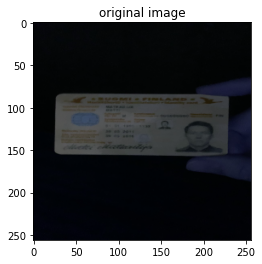

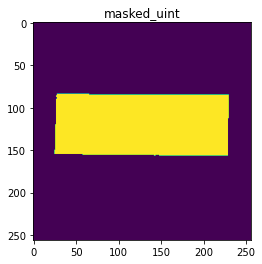

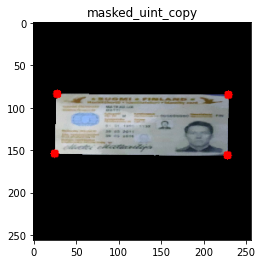

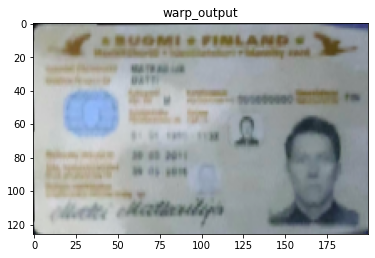

In [37]:
i = random.randint(0, len(X_train))

plt.imshow(X_train[i])
plt.title("original image")
plt.show()

masked = background_removal(X_train[i], Y_train[i])
# plt.imshow(masked)
# plt.title("masked")
# plt.show()

masked_uint, thresh = convert_to_gray_and_threshold(masked, 10)
plt.imshow(thresh)
plt.title("masked_uint")
plt.show()

masked_uint_cntr = contour_detection(masked_uint, thresh)
# plt.imshow(masked_uint_cntr)
# plt.title("masked_uint_cntr")
# plt.show()

pts_corners = corner_detection(masked_uint, thresh, N=4)
# print(pts_corners)
warp_image = warp_perspective(masked_uint, pts_corners)

In [44]:
###Brightness Analysis

warp_image_hsv = cv2.cvtColor(warp_image, cv2.COLOR_BGR2HSV)

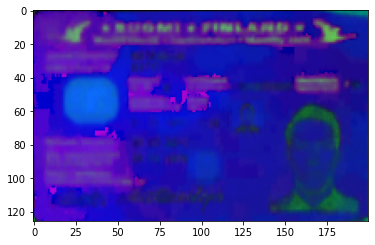

In [45]:
plt.imshow(warp_image_hsv)

In [50]:
#bin dimensions (e, napravi kao klasu!!!)
bin_rows = 18
bin_columns = 20

bin_size = (bin_rows, bin_columns)

bin_row_number = int(warp_image_hsv[:, :, 2].shape[0]/bin_rows)
bin_column_number = int(warp_image_hsv[:, :, 2].shape[1]/bin_columns)

In [51]:
#warp_image_brightnesss_v - holds mean and std values for each bin
alpha_v = 1
warp_image_brightness_v = np.zeros([bin_row_number, bin_column_number, 3])

#blurring image to reduce noise
warp_image_blur = cv2.GaussianBlur(warp_image_hsv, (3,3), 0)

for row_number in range(bin_row_number):
    for column_number in range (bin_column_number):
        #calculating mean and std value for a single bin 
        single_bin = warp_image_hsv[:, :, 2][(row_number*bin_rows):(row_number*bin_rows+bin_rows), (column_number*bin_columns):(column_number*bin_columns+bin_columns)]        
        warp_image_brightness_v[row_number, column_number, 0] = single_bin.mean()
        warp_image_brightness_v[row_number, column_number, 1] = single_bin.std()
        warp_image_brightness_v[row_number, column_number, 2] = single_bin.mean()+alpha_v*single_bin.std()
        #thresholding brightness value on blurred image
        warp_image_blur[:, :, 2][(row_number*bin_rows):(row_number*bin_rows+bin_rows), (column_number*bin_columns):(column_number*bin_columns+bin_columns)] = np.where((warp_image_blur[:, :, 2][(row_number*bin_rows):(row_number*bin_rows+bin_rows), (column_number*bin_columns):(column_number*bin_columns+bin_columns)])<warp_image_brightness_v[row_number, column_number, 2], 0, 255)

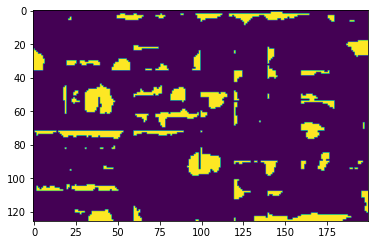

In [99]:
plt.imshow(warp_image_blur[:, :, 2])

In [ ]:
# #display of all labels

# for i in range(numLabels):
#     if i == 0:
#         text = f'examining component {i+1}/{numLabels} (background)'
        
#     else:
#         text = f'examining component {i+1}/{numLabels}'
    
#     print(f'[INFO] {text}')
    
#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP]
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]
#     output_img = warp_image.copy()
#     cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
#     cv2.circle(output_img, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    
#     componentMask = (labels == i).astype("uint8")*255
    
#     cv2.imshow("Output", output_img)
#     cv2.imshow("Connected Component", componentMask)
#     cv2.waitKey(0)

# cv2. destroyAllWindows()

In [97]:
##conected component analysis/labeling or region labeling

output = cv2.connectedComponentsWithStats(warp_image_blur[:, :, 2], 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

#check if any label is larger than certain percentage of complete image
"""
size_limit - percentage of the complete image
"""

size_limit = 0.02
large_chunks = ((stats[1:, 4]/stats[0, 4]) > size_limit).any()
if large_chunks:
    print("Large label detected!")
else:
    print("Sve cool!")

Sve cool!
